In [5]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers
from ast import literal_eval
from gensim.models import KeyedVectors
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

The RNN training parts of this notebook are based on the following:

https://medium.com/@claude.feldges/text-classification-with-tf-idf-lstm-bert-a-quantitative-comparison-b8409b556cb3

In [6]:
### functions

sns.set(font_scale=1.1)

RANDOM_STATE = 12345

def evaluate_classifier(y_test, pred, labels=None):

    fig, ax = plt.subplots(figsize=(8,6))
    # normalize : {'true', 'pred', 'all'}, default=None
    # Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. 
    # If None, confusion matrix will not be normalized.
    cm = confusion_matrix(y_test, pred, normalize=None) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax)
    plt.grid(False)
    plt.show()
    
    print("Accuracy  = " + str(accuracy_score(y_true=y_test, y_pred=pred)))
    print("F1 score  = " + str(f1_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Precision = " + str(precision_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Recall    = " + str(recall_score(y_true=y_test, y_pred=pred, average='weighted')))

In [7]:
df_train = pd.read_csv('../../data/train_data.csv')
df_train['lemmatized'] = df_train['lemmatized'].apply(literal_eval)

df_test = pd.read_csv('../../data/test_data.csv')
df_test['lemmatized'] = df_test['lemmatized'].apply(literal_eval)

df_train.head()

,filename,artist,title,genre,lyrics,instrumental,tokenized,lemmatized
0,country.00041.wav,Johnny Cash,Goin' By The Book,country,\nYou can see it in the movies and the paper a...,False,"['see', 'movies', 'paper', 'tv', 'news', 'some...","[see, movie, paper, tv, news, somebody, army, ..."
1,reggae.00038.wav,Burning Spear,Investigation Dub,reggae,I and I old I know\nI and I old I say\nI and I...,False,"['old', 'know', 'old', 'say', 'reconsider', 's...","[old, know, old, say, reconsider, see, upfully..."
2,disco.00070.wav,KC and The Sunshine Band,That's The Way (I Like It),disco,"That's the way, aha, aha\nI like it, aha, aha\...",False,"['thats', 'way', 'aha', 'aha', 'like', 'aha', ...","[thats, way, aha, aha, like, aha, aha, thats, ..."
3,reggae.00088.wav,Marcia Griffiths,Electric Boogie,reggae,\nIt's electric!\n\n\nYou can't see it\nIt's e...,False,"['electric', 'cant', 'see', 'electric', 'got',...","[electric, cant, see, electric, get, ta, feel,..."
4,pop.00017.wav,Britney Spears,(I Can't Get No) Satisfaction,pop,\nI can't get no satisfaction\nI can't get no ...,False,"['cant', 'get', 'satisfaction', 'cant', 'get',...","[cant, get, satisfaction, cant, get, satisfact..."


In [8]:
# word vectors of the following dimensions are available: 50d, 100d, 200d, 300d 
GLOVE_MODELS = {}

for dim in ["300d"]:#["50d", "100d", "200d", "300d"]:
    glove_path = f"../../glove/glove.6B.{dim}.txt"
    glove_word2vec_path = glove_path + '.word2vec'

    if os.path.exists(glove_word2vec_path):
        # load the Stanford GloVe model
        print(f"Loading saved glove word2vec {dim} model")
        GLOVE_MODELS[dim] = KeyedVectors.load_word2vec_format(glove_word2vec_path, binary=False)
    else:
        # load the Stanford GloVe model from txt file, convert to word2vec and save
        print(f"Creating glove word2vec {dim} model")
        glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)
        glove_model.save_word2vec_format(glove_word2vec_path)
        GLOVE_MODELS[dim] = glove_model

print(GLOVE_MODELS)

Loading saved glove word2vec 300d model
{'300d': <gensim.models.keyedvectors.KeyedVectors object at 0x7fb61692faf0>}


In [9]:
from sklearn.base import BaseEstimator

# create vectorizer that uses glove embeddings
class LyricsVectorizer(BaseEstimator):
    def __init__(self, word_vec_dim="100d", method="mean"):
        self.word_vectors = GLOVE_MODELS[word_vec_dim]
        self.word_vec_dim = word_vec_dim
        self.method = method

    def fit(self, X, y=None):
        return self

    def _transform(self, data):
        # determine the dimensionality of vectors
        vec = np.zeros(self.word_vectors.vector_size)
        
        if type(data) == list:
            #print("Data is tokenized")
            tokenized = True
        elif type(data) == str:
            #print("Data is non-tokenized string")
            tokenized = False
        else:
            print("Not recognized data type")
            return None
        
        if tokenized:
            tokens = data
        else:
            tokens = data.split()
        vecs = []
        for word in tokens:
            try:
                # throws KeyError if word not found
                word_embed = self.word_vectors.get_vector(word)
                vecs.append(word_embed)
            except KeyError:
                pass
        if len(vecs) > 0:
            vecs = np.array(vecs)
            if self.method == "mean":
                vec = vecs.mean(axis=0) # lyrics embedding = mean over all words
            else:
                vec = vecs.sum(axis=0) # lyrics embedding = sum over all words
            # maybe consider concatenation?
        return vec
    
    def transform(self, X):
        return np.concatenate(
            [self._transform(row).reshape(1, -1) for row in X]
            )
    
    def get_params(self, deep=True):
        result = {"word_vec_dim": self.word_vec_dim, "method": self.method}
        return result

In [10]:
from sklearn.preprocessing import LabelBinarizer

# Renaming, Input -> X, Output -> y
#X_tf_train = df_train['lyrics']
#X_tf_test = df_test['lyrics']
X_tf_train = df_train['lemmatized'].apply(' '.join)
X_tf_test = df_test['lemmatized'].apply(' '.join)

# Convert labels into a one-hot vector (length = number of genres)
lab = LabelBinarizer()
lab.fit(df_train['genre'])
y_tf_train = lab.transform(df_train['genre'])
y_tf_test = lab.transform(df_test['genre'])

# Example (you can modify n)
print('Coding of labels into a one-hot vector, e.g.: ')
print(df_train['genre'][0], '->', y_tf_train[0])
print(df_train['genre'][1], ' ->', y_tf_train[1])
print(df_train['genre'][2], '  ->', y_tf_train[2])

Coding of labels into a one-hot vector, e.g.: 
country -> [0 1 0 0 0 0 0 0]
reggae  -> [0 0 0 0 0 0 1 0]
disco   -> [0 0 1 0 0 0 0 0]


In [11]:
corpus = X_tf_train
max_words = 20000
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', num_words=max_words, oov_token="<pad>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

In [46]:
max_len = 300

sequences = tokenizer.texts_to_sequences(X_tf_train)
X_tf_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

# Apply the same to test data
X_tf_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_tf_test), maxlen=max_len)

n=0 # You can adjust n
print('Shape: ',X_tf_train_seq.shape)
print('Example: ',X_tf_train_seq[n,:])

Shape:  (609, 300)
Example:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0   

In [47]:
glove = GLOVE_MODELS["300d"]
corpus_len = len(reverse_voc)
emb_matrix=np.zeros((corpus_len+1, glove.vector_size))

for i in range(corpus_len):
    w = reverse_voc[i+1]
    try:
        # throws KeyError if word not found
        emb_matrix[i+1,:] = glove.get_vector(w)
    except KeyError:
        pass
    
emb_size = emb_matrix.shape[1]
print(emb_matrix.shape)

(7660, 300)


In [88]:
input_ = layers.Input(shape = X_tf_train_seq[0,:].shape, name='input')

# Embedding layer (voc size plus pad token (with index 0), using the pre-trained emb_matrix obtained from glove
x = layers.Embedding(corpus_len+1, emb_size, weights=[emb_matrix], trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(32,dropout=0.2,return_sequences=True), name='bidirectional-lstm1')(x) # LSTM layer 1
x = layers.Bidirectional(layers.LSTM(64,dropout=0.2), name='bidirectional-lstm2')(x) # LSTM layer 2
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(128, activation='relu', name='dense')(x)
output = layers.Dense(df_train['genre'].nunique(), activation='softmax', name='classification')(x)

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.002)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [89]:
model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          2298000   
                                                                 
 bidirectional-lstm1 (Bidire  (None, 300, 64)          85248     
 ctional)                                                        
                                                                 
 bidirectional-lstm2 (Bidire  (None, 128)              66048     
 ctional)                                                        
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               165

In [90]:
start_time = datetime.now()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="300d_model/{val_accuracy:.3f}_acc",
    monitor='val_accuracy',
    mode='max',
    save_weights_only=False,
    save_best_only=True)

history = model.fit(X_tf_train_seq, y_tf_train, batch_size=16, shuffle=True, epochs=40, callbacks=[checkpoint_cb], validation_data=(X_tf_test_seq, y_tf_test))
end_time = datetime.now()

training_time_rnn = (end_time - start_time).total_seconds()

Epoch 1/40
39/39 [==============================] - ETA: 0s - loss: 1.9815 - accuracy: 0.2036

INFO:tensorflow:Assets written to: 300d_model/0.261_acc/assets


INFO:tensorflow:Assets written to: 300d_model/0.261_acc/assets


39/39 [==============================] - 31s 672ms/step - loss: 1.9815 - accuracy: 0.2036 - val_loss: 1.9475 - val_accuracy: 0.2614
Epoch 2/40
39/39 [==============================] - ETA: 0s - loss: 1.8193 - accuracy: 0.3021

INFO:tensorflow:Assets written to: 300d_model/0.301_acc/assets


INFO:tensorflow:Assets written to: 300d_model/0.301_acc/assets


39/39 [==============================] - 24s 623ms/step - loss: 1.8193 - accuracy: 0.3021 - val_loss: 1.8511 - val_accuracy: 0.3007
Epoch 3/40
39/39 [==============================] - 10s 257ms/step - loss: 1.5976 - accuracy: 0.4450 - val_loss: 1.9239 - val_accuracy: 0.3007
Epoch 4/40
39/39 [==============================] - ETA: 0s - loss: 1.3746 - accuracy: 0.5156

INFO:tensorflow:Assets written to: 300d_model/0.386_acc/assets


INFO:tensorflow:Assets written to: 300d_model/0.386_acc/assets


39/39 [==============================] - 27s 713ms/step - loss: 1.3746 - accuracy: 0.5156 - val_loss: 1.8324 - val_accuracy: 0.3856
Epoch 5/40
39/39 [==============================] - 9s 242ms/step - loss: 1.3302 - accuracy: 0.5123 - val_loss: 1.8940 - val_accuracy: 0.3725
Epoch 6/40
39/39 [==============================] - 10s 260ms/step - loss: 1.0893 - accuracy: 0.6108 - val_loss: 1.8104 - val_accuracy: 0.3791
Epoch 7/40
39/39 [==============================] - 10s 254ms/step - loss: 0.8064 - accuracy: 0.7225 - val_loss: 1.9704 - val_accuracy: 0.3725
Epoch 8/40
39/39 [==============================] - ETA: 0s - loss: 0.6067 - accuracy: 0.7816

INFO:tensorflow:Assets written to: 300d_model/0.418_acc/assets


INFO:tensorflow:Assets written to: 300d_model/0.418_acc/assets


39/39 [==============================] - 27s 707ms/step - loss: 0.6067 - accuracy: 0.7816 - val_loss: 2.1116 - val_accuracy: 0.4183
Epoch 9/40
39/39 [==============================] - ETA: 0s - loss: 0.4807 - accuracy: 0.8456

INFO:tensorflow:Assets written to: 300d_model/0.438_acc/assets


INFO:tensorflow:Assets written to: 300d_model/0.438_acc/assets


39/39 [==============================] - 27s 694ms/step - loss: 0.4807 - accuracy: 0.8456 - val_loss: 2.2936 - val_accuracy: 0.4379
Epoch 10/40
39/39 [==============================] - 10s 251ms/step - loss: 0.3809 - accuracy: 0.8719 - val_loss: 2.6475 - val_accuracy: 0.4052
Epoch 11/40
39/39 [==============================] - 10s 256ms/step - loss: 0.2770 - accuracy: 0.9048 - val_loss: 2.8444 - val_accuracy: 0.3660
Epoch 12/40
39/39 [==============================] - 11s 281ms/step - loss: 0.3563 - accuracy: 0.8785 - val_loss: 2.7272 - val_accuracy: 0.3922
Epoch 13/40
39/39 [==============================] - 11s 277ms/step - loss: 0.2511 - accuracy: 0.9146 - val_loss: 2.8808 - val_accuracy: 0.4118
Epoch 14/40
39/39 [==============================] - 11s 270ms/step - loss: 0.3147 - accuracy: 0.9146 - val_loss: 3.0507 - val_accuracy: 0.3922
Epoch 15/40
39/39 [==============================] - 11s 276ms/step - loss: 0.1772 - accuracy: 0.9409 - val_loss: 2.8807 - val_accuracy: 0.4248
Epoc

INFO:tensorflow:Assets written to: 300d_model/0.444_acc/assets


INFO:tensorflow:Assets written to: 300d_model/0.444_acc/assets


39/39 [==============================] - 27s 712ms/step - loss: 0.0268 - accuracy: 0.9934 - val_loss: 3.6285 - val_accuracy: 0.4444
Epoch 23/40
39/39 [==============================] - 10s 262ms/step - loss: 0.0283 - accuracy: 0.9934 - val_loss: 3.7534 - val_accuracy: 0.4379
Epoch 24/40
39/39 [==============================] - 11s 272ms/step - loss: 0.0477 - accuracy: 0.9852 - val_loss: 3.8860 - val_accuracy: 0.3595
Epoch 25/40
39/39 [==============================] - 11s 276ms/step - loss: 0.3718 - accuracy: 0.8949 - val_loss: 2.9486 - val_accuracy: 0.3922
Epoch 26/40
39/39 [==============================] - 11s 291ms/step - loss: 0.1342 - accuracy: 0.9540 - val_loss: 3.5740 - val_accuracy: 0.3464
Epoch 27/40
39/39 [==============================] - 11s 294ms/step - loss: 0.0635 - accuracy: 0.9869 - val_loss: 3.7743 - val_accuracy: 0.4052
Epoch 28/40
39/39 [==============================] - 11s 282ms/step - loss: 0.0754 - accuracy: 0.9770 - val_loss: 3.7831 - val_accuracy: 0.4118
Epoc

INFO:tensorflow:Assets written to: 300d_model/0.458_acc/assets


INFO:tensorflow:Assets written to: 300d_model/0.458_acc/assets


39/39 [==============================] - 29s 746ms/step - loss: 0.0141 - accuracy: 0.9967 - val_loss: 3.9417 - val_accuracy: 0.4575
Epoch 37/40
39/39 [==============================] - 10s 267ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 4.0816 - val_accuracy: 0.4510
Epoch 38/40
39/39 [==============================] - 11s 277ms/step - loss: 0.0140 - accuracy: 0.9951 - val_loss: 4.2291 - val_accuracy: 0.4444
Epoch 39/40
39/39 [==============================] - 10s 269ms/step - loss: 0.0398 - accuracy: 0.9885 - val_loss: 4.1773 - val_accuracy: 0.4183
Epoch 40/40
39/39 [==============================] - 11s 283ms/step - loss: 0.0476 - accuracy: 0.9836 - val_loss: 4.2446 - val_accuracy: 0.3856



Accuracy Training data:  98.69%
Accuracy Test data:      48.37%
Training time: 174.0 sec



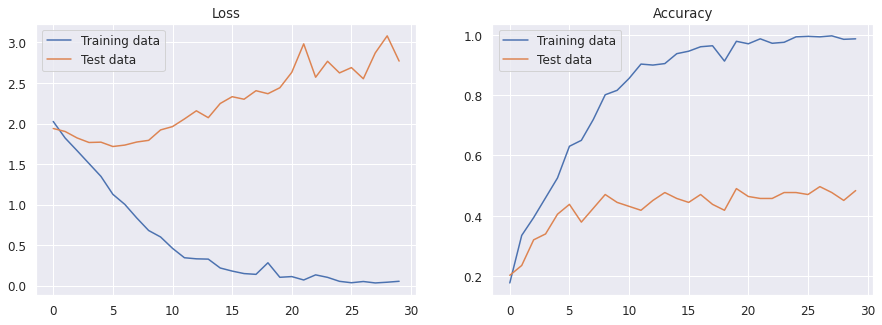

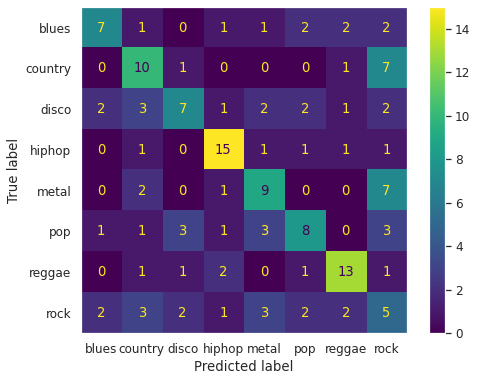

Accuracy  = 0.48366013071895425
F1 score  = 0.4870034203170614
Precision = 0.5001796678267266
Recall    = 0.48366013071895425


In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training data')
ax[0].plot(history.history['val_loss'], label='Test data')
ax[0].legend(loc="upper left")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training data')
ax[1].plot(history.history['val_accuracy'], label='Test data')
ax[1].legend(loc="upper left")

print("")
accuracy_rnn = history.history['val_accuracy'][-1]
print('Accuracy Training data:  {:.2%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data:      {:.2%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f} sec'.format(training_time_rnn))
print("")

pred_prob = model.predict(X_tf_test_seq)
pred = np.argmax(pred_prob, axis=1)
pred = lab.classes_[pred].tolist()
evaluate_classifier(df_test['genre'], pred, lab.classes_)